In [1]:
import pandas
import numpy as np
import tensorflow as tf
import os
import math
import random as rand
from random import random

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data Preparation

In [2]:
trainDataFile = 'ijcnlp_dailydialog/train/dialogues_train.txt'
trainLabelsFile = 'ijcnlp_dailydialog/train/dialogues_act_train.txt' 

In [3]:
valDataFile = 'ijcnlp_dailydialog/validation/dialogues_validation.txt'
valLablesFile = 'ijcnlp_dailydialog/validation/dialogues_act_validation.txt'

In [4]:
testDataFile = 'ijcnlp_dailydialog/test/dialogues_test.txt'
testLablesFile = 'ijcnlp_dailydialog/test/dialogues_act_test.txt'

In [5]:
lineSeparator = '__eou__'

In [6]:
def getData(dialogueFile, labelFile):
    with open(dialogueFile) as f:
        lines = f.readlines() 
    with open(labelFile) as f:
        labels = f.readlines()    
    
    inputs = []
    inputs_all = []
    for line in lines:
        line = line.rstrip()
        line = line.split(lineSeparator)
        inputs.append(line[:-1])
        inputs_all.extend(line[:-1])
    
    acts = []
    acts_all = []
    for label in labels:
        label = label.rstrip()
        label = label.split()
        
        label = np.array(list(map(int, label))) - 1
        acts.append(label)
        acts_all.extend(label)
        
    return (inputs_all, inputs, acts_all, acts)

In [7]:
trainX_all, trainX_data, trainY_all, trainY = getData(trainDataFile, trainLabelsFile)
valX_all, valX_data, valY_all, valY = getData(valDataFile, valLablesFile)
testX_all, testX_data, testY_all, testY = getData(testDataFile, testLablesFile)

In [8]:
train_dialogues = len(trainX_all)
val_dialogues = len(valX_all)
test_dialogues = len(testX_all)
fullData_temp = trainX_all + valX_all + testX_all

In [9]:
embed_size = 300;
pad_token = '<pad>'
unknown_token = '<unk>'
embed_path = '/home/abhishekjindal/nlp/data/glove.840B.300d.txt'

In [10]:
%matplotlib inline

from random import randint
import matplotlib

import numpy as np
import torch

torch.nn.Module.dump_patches = True

In [11]:
# sentEmbedModel = torch.load('encoder/infersent.allnli.pickle', map_location=lambda storage, loc: storage)

sentEmbedModel = torch.load('encoder/infersent.allnli.pickle')
sentEmbedModel = sentEmbedModel.cuda()

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. Saved a reverse patch to BLSTMEncoder.patch. Run `patch -p0 < BLSTMEncoder.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. Saved a reverse patch to LSTM.patch. Run `patch -p0 < LSTM.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)


In [12]:
sentEmbedModel.is_cuda()

True

In [13]:
sentEmbedModel.set_glove_path(embed_path)

In [17]:
%%time
sentEmbedModel.build_vocab(fullData_temp, tokenize=True)
#sentEmbedModel.build_vocab_k_words(K=100000)

Found 23332(/26376) words with glove vectors
Vocab size : 23332
CPU times: user 28.4 s, sys: 1.59 s, total: 30 s
Wall time: 30 s


In [18]:
%%time
final_emb = sentEmbedModel.encode(fullData_temp, bsize=128, tokenize=False, verbose=False)

CPU times: user 42.9 s, sys: 22.5 s, total: 1min 5s
Wall time: 1min 5s


In [19]:
final_emb.shape

(102979, 4096)

In [20]:
curr_count = 0
train_emb_data = final_emb[curr_count:(curr_count+train_dialogues)]
curr_count += train_dialogues
val_emb_data = final_emb[curr_count:(curr_count+val_dialogues)]
curr_count += val_dialogues
test_emb_data = final_emb[curr_count:(curr_count+test_dialogues)]
print(curr_count+test_dialogues)

102979


# Train a classifier

In [21]:
# Parameters used.
MODEL_PATH = './model_crf_v6.ckpt'

In [22]:
def get_sequence_length(x_data):
    seq = [];
    for i in range(len(x_data)):
        seq.append(len(x_data[i]))
    return seq

In [23]:
def create_embedding_conversation_data(complete_emb, seq_len):
    curr_count = 0;
    final_data = [];
    #print(complete_emb[0:2])
    for i in range(len(seq_len)):
        
        emb_temp = complete_emb[curr_count:(curr_count+seq_len[i])]
        final_data.append(emb_temp)
        curr_count += seq_len[i]
    return final_data

In [24]:

sequence_length_train = get_sequence_length(trainX_data)
sequence_length_val = get_sequence_length(valX_data)
sequence_length_test = get_sequence_length(testX_data)

x_train = create_embedding_conversation_data(train_emb_data, sequence_length_train)
x_val = create_embedding_conversation_data(val_emb_data, sequence_length_val)
x_test = create_embedding_conversation_data(test_emb_data, sequence_length_test)

y_train = trainY
y_val = valY
y_test = testY


In [25]:
learning_rate = 0.05
#training_epochs = 7
input_size = 4096 #sent_embed_size
#batch_size = 25
#num_units = 128 # the number of units in the LSTM cell
number_of_classes = len(set(trainY_all))

In [26]:
def pad_label(sentence, max_length):
    pad_len = max_length - len(sentence)
    padding = np.zeros(pad_len, dtype=int)
    return np.concatenate((sentence, padding))

In [27]:
input_data = tf.placeholder(tf.float32, [None, None, input_size], name="input_data") # shape = (batch, batch_seq_len, input_size)
labels = tf.placeholder(tf.int32, shape=[None, None], name="labels") # shape = (batch, sentence)
batch_sequence_length = tf.placeholder(tf.int32) # max sequence length in batch
original_sequence_lengths = tf.placeholder(tf.int32, [None])


In [28]:
weights = tf.get_variable("weights", [input_size, number_of_classes])
matricized_x_train = tf.reshape(input_data, [-1, input_size])
matricized_unary_scores = tf.matmul(matricized_x_train, weights)
#matricized_unary_scores = tf.sigmoid(matricized_unary_scores_temp)
scores = tf.reshape(matricized_unary_scores, [-1, batch_sequence_length, number_of_classes])
#scores = tf.reshape(matricized_unary_scores, [num_examples, num_words, num_tags])


In [29]:
# Linear-CRF.
log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(scores, labels, original_sequence_lengths)

loss = tf.reduce_mean(-log_likelihood)

# Compute the viterbi sequence and score (used for prediction and test time).
viterbi_sequence, viterbi_score = tf.contrib.crf.crf_decode(scores, transition_params, original_sequence_lengths)

# Training ops.
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [30]:
def pad_data(sentence, max_length, input_size):
#     sent_emb = np.array([create_sentence_embed(x, word_emb, embed_size, unknown_token, pad_token, calc_mean = True) for x in sentence])
    #sent_emb = np.array([create_sentence_embed_facebook(x) for x in sentence])
    pad_len = max_length - len(sentence)
    temp = sentence
    if pad_len > 0:
        single_pad = np.zeros(input_size)
        padding = [single_pad] * pad_len
#         print(pad_len)
#         print(len(sent_emb), len(padding))
#         print(type(sent_emb), type(padding))
#         print(sent_emb.shape)
        #sent_emb = sent_emb.squeeze()
        temp = np.concatenate((temp, padding))
    return temp

In [31]:
def batch(data, labels, sequence_lengths, batch_size, input_size):
    n_batch = int(math.ceil(float(len(data)) / (batch_size)))
    index = 0
    for _ in range(n_batch):
#         print(_)
        batch_sequence_lengths = np.array(sequence_lengths[index: index + batch_size])
#         print(batch_sequence_lengths)
        batch_length = np.array(max(batch_sequence_lengths)) # max length in batch
#         print(batch_length)
#         for x in data[index: index + batch_size]:
#             xx = pad_data(x, batch_length, input_size)
#             print(xx.shape)
        batch_data = np.array([pad_data(x, batch_length, input_size).squeeze() for x in data[index: index + batch_size]]) # pad data
        batch_labels = np.array([pad_label(x, batch_length) for x in labels[index: index + batch_size]]) # pad labels
        index += batch_size
        
        # Reshape input data to be suitable for LSTMs.
        batch_data = batch_data.reshape(-1, batch_length, input_size)
        
        yield batch_data, batch_labels, batch_length, batch_sequence_lengths

In [53]:
%%time 
training_epochs = 15;
batch_size = 800;
cnt = 0;
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    for i in range(training_epochs):
        for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_train, y_train, sequence_length_train, batch_size, input_size):
            cnt += 1
            tf_viterbi_sequence, _ = session.run([viterbi_sequence, train_op], 
                                                 feed_dict={input_data: batch_data, 
                                                            labels: batch_labels, 
                                                            batch_sequence_length: batch_seq_len,
                                                            original_sequence_lengths: batch_sequence_lengths })
            # Show train accuracy.
            if i % 1 == 0:
                # Create a mask to fix input lengths.
                mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
                    np.expand_dims(batch_sequence_lengths, axis=1))
                total_labels = np.sum(batch_sequence_lengths)
                correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
                accuracy = 100.0 * correct_labels / float(total_labels)
                print("Epoch: %d" % i, "Accuracy: %.2f%%" % accuracy)
#             if (cnt*batch_size) % 10000 ==0:
    # Save the variables to disk.
        
        print("Saving model")
        saver.save(session, MODEL_PATH)

Epoch: 0 Accuracy: 9.21%
Epoch: 0 Accuracy: 59.23%
Epoch: 0 Accuracy: 64.89%
Epoch: 0 Accuracy: 62.60%
Epoch: 0 Accuracy: 76.07%
Epoch: 0 Accuracy: 70.40%
Epoch: 0 Accuracy: 37.67%
Epoch: 0 Accuracy: 50.02%
Epoch: 0 Accuracy: 60.86%
Epoch: 0 Accuracy: 60.96%
Epoch: 0 Accuracy: 59.71%
Epoch: 0 Accuracy: 46.19%
Epoch: 0 Accuracy: 45.28%
Epoch: 0 Accuracy: 60.33%
Saving model
Epoch: 1 Accuracy: 67.91%
Epoch: 1 Accuracy: 75.72%
Epoch: 1 Accuracy: 80.51%
Epoch: 1 Accuracy: 78.95%
Epoch: 1 Accuracy: 79.96%
Epoch: 1 Accuracy: 76.19%
Epoch: 1 Accuracy: 64.99%
Epoch: 1 Accuracy: 66.57%
Epoch: 1 Accuracy: 61.69%
Epoch: 1 Accuracy: 62.90%
Epoch: 1 Accuracy: 66.66%
Epoch: 1 Accuracy: 64.10%
Epoch: 1 Accuracy: 63.70%
Epoch: 1 Accuracy: 66.40%
Saving model
Epoch: 2 Accuracy: 76.22%
Epoch: 2 Accuracy: 75.49%
Epoch: 2 Accuracy: 76.69%
Epoch: 2 Accuracy: 78.24%
Epoch: 2 Accuracy: 80.64%
Epoch: 2 Accuracy: 79.69%
Epoch: 2 Accuracy: 69.81%
Epoch: 2 Accuracy: 68.60%
Epoch: 2 Accuracy: 67.62%
Epoch: 2 Accu

In [54]:
%%time
# Testing the model.
with tf.Session() as session:
    # Restore variables from disk.
    saver.restore(session, MODEL_PATH)
    
    for batch_data, batch_labels, batch_seq_len, batch_sequence_lengths in batch(x_val, y_val, sequence_length_val, len(x_val), input_size):
        tf_viterbi_sequence = session.run(viterbi_sequence, feed_dict={input_data: batch_data, 
                                                                       labels: batch_labels, 
                                                                       batch_sequence_length: batch_seq_len,
                                                                       original_sequence_lengths: batch_sequence_lengths })
    # mask to correct input sizes
    mask = (np.expand_dims(np.arange(batch_seq_len), axis=0) <
        np.expand_dims(batch_sequence_lengths, axis=1))
    total_labels = np.sum(batch_sequence_lengths)
    correct_labels = np.sum((batch_labels == tf_viterbi_sequence) * mask)
    accuracy = 100.0 * correct_labels / float(total_labels)
    print("Test accuracy: %.2f%%" % accuracy)

    print("Label:", batch_labels[0].astype(int))    
    print("Pred.:", tf_viterbi_sequence[0])

INFO:tensorflow:Restoring parameters from ./model_crf_v6.ckpt
Test accuracy: 76.03%
Label: [1 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred.: [1 1 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
CPU times: user 839 ms, sys: 1.21 s, total: 2.05 s
Wall time: 1.91 s


# Evaluation

In [55]:
from sklearn import metrics

In [56]:
preds = []
for i in range(len(sequence_length_test)):
    preds.extend(tf_viterbi_sequence[i][:sequence_length_val[i]])

In [57]:
metrics.accuracy_score(valY_all, preds)

0.7603172636014376

In [58]:
print(metrics.classification_report(valY_all, preds))

             precision    recall  f1-score   support

          0       0.79      0.77      0.78      3125
          1       0.90      0.91      0.90      2244
          2       0.66      0.62      0.64      1775
          3       0.53      0.64      0.58       925

avg / total       0.76      0.76      0.76      8069



In [59]:
cmat = metrics.confusion_matrix(valY_all, preds)

In [60]:
cmat.diagonal()/cmat.sum(axis=1)

array([0.77056   , 0.90508021, 0.62422535, 0.63567568])

In [61]:
cmat

array([[2408,   40,  314,  363],
       [  21, 2031,  171,   21],
       [ 366,  173, 1108,  128],
       [ 241,   15,   81,  588]])

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
import itertools

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
classes = ['inform', 'question', 'directive', 'commisive']

Confusion matrix, without normalization
[[2408   40  314  363]
 [  21 2031  171   21]
 [ 366  173 1108  128]
 [ 241   15   81  588]]


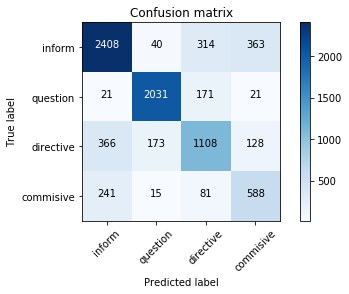

In [66]:
plot_confusion_matrix(cmat, classes)

Normalized confusion matrix
[[0.77056    0.0128     0.10048    0.11616   ]
 [0.00935829 0.90508021 0.07620321 0.00935829]
 [0.20619718 0.09746479 0.62422535 0.07211268]
 [0.26054054 0.01621622 0.08756757 0.63567568]]


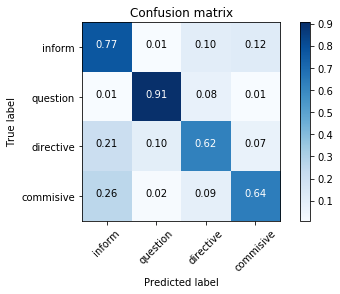

In [67]:
plot_confusion_matrix(cmat, classes, normalize=True)

In [68]:
correctPerClass = {}
totalPerClass   = {}
for cls in [0, 1, 2, 3]:
    correctPerClass[cls] = 0
    totalPerClass[cls]   = 0
for yt, yp in zip(valY_all, preds):
    totalPerClass[yt] += 1
    correctPerClass[yt] += int(yt==yp)



In [69]:
totalPerClass

{0: 3125, 1: 2244, 2: 1775, 3: 925}

In [70]:
correctPerClass

{0: 2408, 1: 2031, 2: 1108, 3: 588}

In [71]:
for cls in [0, 1, 2, 3]:
    acc = float(correctPerClass[cls])/totalPerClass[cls]
    print("Accuracy for class ", cls, " :", acc)

Accuracy for class  0  : 0.77056
Accuracy for class  1  : 0.9050802139037433
Accuracy for class  2  : 0.624225352112676
Accuracy for class  3  : 0.6356756756756756


# Saving the transition params

In [72]:
x = tf.Variable([[1.0, 2.0], [3, 1]])

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
v = sess.run(transition_params)    

In [73]:
np.savetxt('transition_params_crf_v6.csv', v, delimiter=',')